<a href="https://colab.research.google.com/github/Vidi005/Klasifikasi-3-Jenis-Beras-Tumpukan/blob/master/Klasifikasi%203%20Jenis%20Beras%20VGG%2016%20Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikasi Jenis Beras

# **Mengambil Dataset dari Github**

In [24]:
!apt-get install subversion > /dev/null

!svn export https://github.com/Vidi005/Klasifikasi-3-Jenis-Beras-Tumpukan/trunk/data > /dev/null
#!svn export https://github.com/Vidi005/Klasifikasi-3-Jenis-Beras-Tumpukan/trunk/utils > /dev/null
#!svn export https://github.com/Vidi005/Klasifikasi-3-Jenis-Beras-Tumpukan/trunk/Klasifikasi Beras Tumpukan.ipynb > /dev/null

svn: E155000: Destination directory exists; please remove the directory or use --force to overwrite
svn: E155000: 'data' already exists


## Persiapan

Program ini dibuat untuk membedakan 3 jenis beras yaitu :

1.   Jenis Beras IR 64
2.   Jenis Beras Cilamaya
3.   Jenis Beras Ketan

Pada program ini menggunakan metode Convolutional Neural Network (CNN) untuk melakukan klasifikasinya.

## Memasukan Fungsi Library

In [0]:
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

## Mengimpor Dataset

In [26]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls data/image
!ls data/image/train
!ls data/image/train/Cilamaya
!ls data/image/train/IR64
!ls data/image/train/Ketan

test  test.txt	train  train.txt
Cilamaya  IR64	Ketan
C10.jpg  C16.jpg  C21.jpg  C27.jpg  C32.jpg  C38.jpg  C43.jpg  C49.jpg	C8.jpg
C11.jpg  C17.jpg  C22.jpg  C28.jpg  C33.jpg  C39.jpg  C44.jpg  C4.jpg	C9.jpg
C12.jpg  C18.jpg  C23.jpg  C29.jpg  C34.jpg  C3.jpg   C45.jpg  C50.jpg
C13.jpg  C19.jpg  C24.jpg  C2.jpg   C35.jpg  C40.jpg  C46.jpg  C5.jpg
C14.jpg  C1.jpg   C25.jpg  C30.jpg  C36.jpg  C41.jpg  C47.jpg  C6.jpg
C15.jpg  C20.jpg  C26.jpg  C31.jpg  C37.jpg  C42.jpg  C48.jpg  C7.jpg
I10.jpg  I16.jpg  I21.jpg  I27.jpg  I32.jpg  I38.jpg  I43.jpg  I49.jpg	I8.jpg
I11.jpg  I17.jpg  I22.jpg  I28.jpg  I33.jpg  I39.jpg  I44.jpg  I4.jpg	I9.jpg
I12.jpg  I18.jpg  I23.jpg  I29.jpg  I34.jpg  I3.jpg   I45.jpg  I50.jpg
I13.jpg  I19.jpg  I24.jpg  I2.jpg   I35.jpg  I40.jpg  I46.jpg  I5.jpg
I14.jpg  I1.jpg   I25.jpg  I30.jpg  I36.jpg  I41.jpg  I47.jpg  I6.jpg
I15.jpg  I20.jpg  I26.jpg  I31.jpg  I37.jpg  I42.jpg  I48.jpg  I7.jpg
K10.jpg  K16.jpg  K21.jpg  K27.jpg  K32.jpg  K38.jpg  K43.jpg  K49.jpg	K8.j

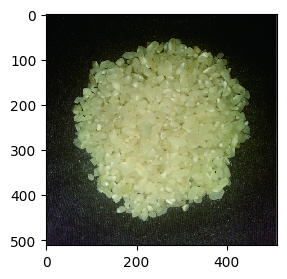

In [27]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("data/image/train/Cilamaya/C17.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [28]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
X_train = []
y_train = []
labels = ['Cilamaya', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("data/image/train",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_train.append(image)
        category = os.path.split(folder)[-1]
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Cilamaya', 'IR64', 'Ketan']

for i,label in enumerate(labels):
    folder = os.path.join("data/image/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Bentuk array dari dataset train (pelatihan) adalah:", X_train.shape,y_train.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Bentuk array dari dataset train (pelatihan) adalah: (150, 224, 224, 3) (150,)
Bentuk array dari dataset test (pengujian) adalah: (30, 224, 224, 3) (30,)


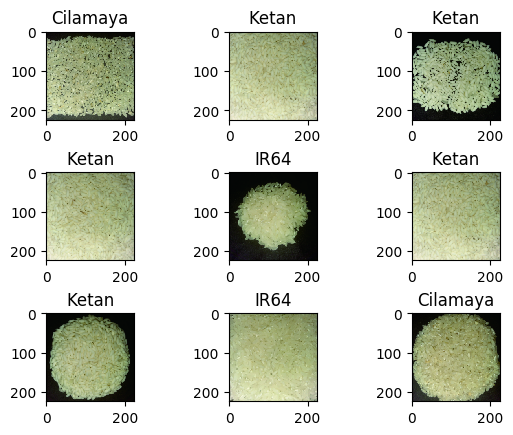

In [29]:
plt.subplots_adjust(wspace=0.4, hspace=0.6)

#Menampilkan beberapa gambar dari dataset pelatihan secara acak
index = np.random.randint(0,X_train.shape[0],size=9)

for i, idx  in enumerate(index):
    plt.subplot(3,3,i+1)
    
    if y_train[idx] == 0:
        label = "Cilamaya"
    elif y_train[idx] == 1:
        label = "IR64"
    else:
        label = "Ketan"
    plt.title(label)
    plt.imshow(X_train[idx])

# Create model from pre-trained convnets

In [30]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model VGG16
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

58892288/58889256 [==============================] - 5s 0us/step


## Feature Extraction

In [0]:
base_model.trainable = False

# Mengelompokkan Klasifikasi Tiga Jenis Beras dengan Deep learning (Convolutional Neural Network)

Sesudah mengimpor dataset, kita akan menggunakan CNN, salah satu arsitektur Deep Learning yang dapat menghandle gambar. Dengan menggunakan Deep CNN, kita dibebaskan dari pendefinisian fitur yang cocok dan hanya memberikan gambar-gambar ke jaringan. CNN akan menentukan fitur yang paling cocok untuk pengklasifikasian.

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

## Mempersiapkan Data Masukkan

In [0]:
y_train2 = to_categorical(y_train)
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_train, y_train2, train_size=0.8, random_state=42)
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

## Pembuatan Model (Menambah Model)

In [36]:
#K.clear_session()
model = tf.keras.Sequential([
    base_model,
    ##tf.keras.layers.Conv2D(16, (3,3), input_shape=(224,224,3),name="conv1"),
    ##tf.keras.layers.Activation("relu"),
    ##tf.keras.layers.MaxPool2D((2,2),name="pool1",padding="same"),
    #layers.Dropout(0.25),
    ##tf.keras.layers.Conv2D(32, (3,3),name="conv2"),
    ##tf.keras.layers.Activation("relu"),
    ##tf.keras.layers.MaxPool2D((2,2),name="pool2",padding="same"),
    #layers.Dropout(0.25),
    #layers.Conv2D(224, (3,3),name="conv3"),
    #layers.Activation("relu"),
    #layers.MaxPool2D((2,2),name="pool3"),
    #layers.Dropout(0.25),
    #layers.Conv2D(512, (3,3),name="conv4"),
    #layers.Activation("relu"),
    #layers.MaxPool2D((2,2),name="pool4"),
    #layers.Dropout(0.25),
    #layers.Conv2D(512, (3,3),name="conv5"),
    #layers.Activation("relu"),
    #layers.MaxPool2D((2,2),name="pool5"),
    #layers.Dropout(0.25),
    ##tf.keras.layers.Flatten(),
    #layers.Dense(64,name="fc1"),
    #layers.Activation("relu"),
    ##tf.keras.layers.Dense(3,name="fc"),
    ##tf.keras.layers.Activation("softmax")

    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          147488    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 14,862,275
Trainable params: 147,587
Non-trainable params: 14,714,688
_________________________________________________________________


## Pelatihan

In [37]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit(x = X_train3, y = y_train3, batch_size=120, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

Train on 120 samples, validate on 30 samples
Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.66449, saving model to Klasifikasi Beras Tumpukan.h5
120/120 [==============================] - 5s 40ms/sample - loss: 1.1543 - acc: 0.4000 - val_loss: 1.6645 - val_acc: 0.3000
Epoch 2/100

Epoch 00002: val_loss improved from 1.66449 to 0.99108, saving model to Klasifikasi Beras Tumpukan.h5
120/120 [==============================] - 0s 4ms/sample - loss: 1.5422 - acc: 0.3417 - val_loss: 0.9911 - val_acc: 0.4667
Epoch 3/100

Epoch 00003: val_loss improved from 0.99108 to 0.91352, saving model to Klasifikasi Beras Tumpukan.h5
120/120 [==============================] - 0s 4ms/sample - loss: 1.0065 - acc: 0.5667 - val_loss: 0.9135 - val_acc: 0.7000
Epoch 4/100

Epoch 00004: val_loss improved from 0.91352 to 0.90546, saving model to Klasifikasi Beras Tumpukan.h5
120/120 [==============================] - 0s 4ms/sample - loss: 1.0036 - acc: 0.5917 - val_loss: 0.9055 - val_acc: 0.6667
Epoch 

## Menggambarkan Hasil Pelatihan

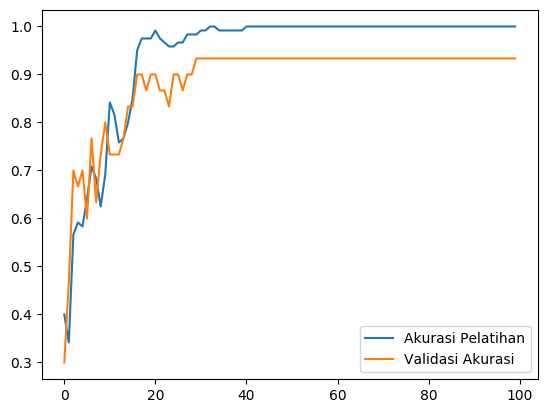

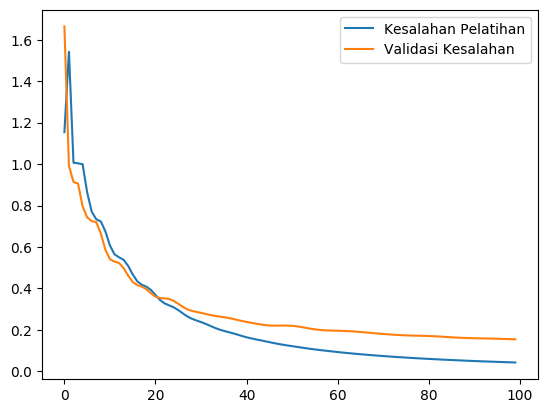

In [38]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

# Fine Tunning

In [0]:
base_model.trainable = True

In [40]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  19


## Compile the model

In [0]:
#K.clear_session()
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [42]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 32)          147488    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 14,862,275
Trainable params: 147,587
Non-trainable params: 14,714,688
_________________________________________________________________


In [43]:
print('Number of trainable variables = {}'.format(len(model.trainable_variables)))

Number of trainable variables = 4


## Continue train model

In [44]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
ckpt = ModelCheckpoint("Klasifikasi Beras Tumpukan Fine Tuned.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history_fine = model.fit(x = X_train3, y = y_train3, epochs= 50,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

Train on 120 samples, validate on 30 samples
Epoch 1/50
 96/120 [=======================>......] - ETA: 0s - loss: 0.0386 - acc: 1.0000
Epoch 00001: val_loss improved from inf to 0.15648, saving model to Klasifikasi Beras Tumpukan Fine Tuned.h5
120/120 [==============================] - 3s 25ms/sample - loss: 0.0417 - acc: 1.0000 - val_loss: 0.1565 - val_acc: 0.9333
Epoch 2/50
 96/120 [=======================>......] - ETA: 0s - loss: 0.0431 - acc: 1.0000
Epoch 00002: val_loss improved from 0.15648 to 0.15466, saving model to Klasifikasi Beras Tumpukan Fine Tuned.h5
120/120 [==============================] - 1s 4ms/sample - loss: 0.0413 - acc: 1.0000 - val_loss: 0.1547 - val_acc: 0.9333
Epoch 3/50
 96/120 [=======================>......] - ETA: 0s - loss: 0.0456 - acc: 1.0000
Epoch 00003: val_loss improved from 0.15466 to 0.15365, saving model to Klasifikasi Beras Tumpukan Fine Tuned.h5
120/120 [==============================] - 1s 4ms/sample - loss: 0.0412 - acc: 1.0000 - val_loss: 0.

## Plotting Graphs

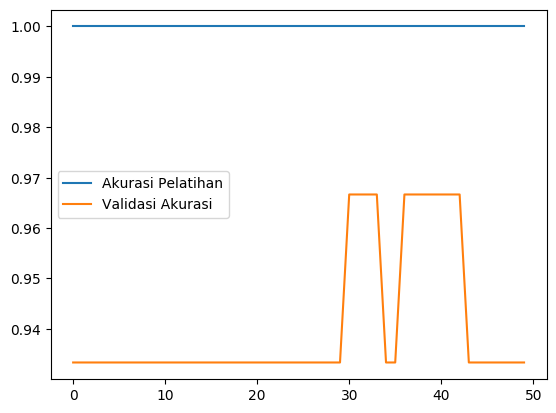

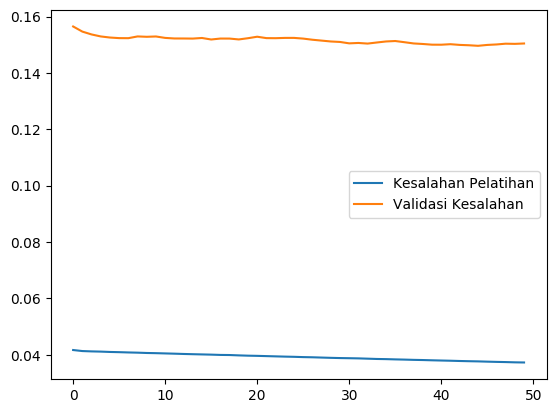

In [45]:
plt.plot(history_fine.history["acc"],label="Akurasi Pelatihan")
plt.plot(history_fine.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history_fine.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history_fine.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

## Menggunakan Model

In [46]:
print(X_train3.shape)

(120, 224, 224, 3)


In [47]:
n = 59
input_image = X_train3[n][np.newaxis,...]
print("Labelnya adalah: ", y_train3[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 1. 0.]
Prediksinya adalah [0.04413802 0.942302   0.0135599 ]


Hasil tersebut merupakan hasil prediksi dari training dari 3 jenis data pelatihan yaitu jenis beras Cilamaya, IR 64, dan Ketan. Menggunakan inputan gambar dengan piksel 224 x 224, 2 filter (hidden layer) dengan fungsi aktivasi relu, dan 1 layer output dengan fungsi aktivasi softmax

## Evaluasi

In [0]:
#Memuat file bobot model keras ".h5" dengan paling sedikit data validasi yang hilang/error
#File ini akan dikonversi ke tensorflow lite
model.load_weights("Klasifikasi Beras Tumpukan.h5")

In [49]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(x= X_train3, y = y_train3))
#Evaluasi validasi data
print(model.evaluate(x= X_valid3, y = y_valid3))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
120/120 [==============================] - 0s 3ms/sample - loss: 0.0413 - acc: 1.0000
[0.04132038354873657, 1.0]
30/30 [==============================] - 0s 3ms/sample - loss: 0.1537 - acc: 0.9333
[0.15369802713394165, 0.93333334]
30/30 [==============================] - 0s 3ms/sample - loss: 0.1127 - acc: 0.9333
[0.11269084364175797, 0.93333334]


In [50]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 0 1 1 2 2 2 2 2 2 2 2 2 2]


## Prediksi Gambar Individual

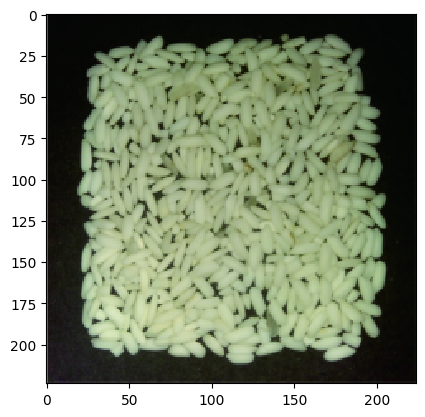

Label yang benar adalah: 2 : Ketan
Nilai yang diprediksi adalah: [5.3122999e-06 4.8933044e-04 9.9950540e-01]
Label yang diprediksi adalah: 2 : Ketan
Prediksi benar


In [51]:
n = 29 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")